Libraries (don't change)

In [1]:
# Github Link:
#Ameer Espanioly - 213471618: https://github.com/Ameer618/Machine_Learning_Ex2
#Baraa Shaqir - 213971294 - https://github.com/Baraash2003/Machine_learning_project_2
#Deema Shaqir - 314947623 - https://github.com/deemashaqir/Machine_learning_project2

!pip -q install torchinfo

from dataclasses import dataclass
from typing import List, Callable, Optional, Tuple

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline


Device (don't change)

In [2]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
use_amp = (DEVICE == "cuda")

print(f"Using device: {DEVICE}")
print(f"Mixed precision (AMP): {use_amp}")

Using device: cuda
Mixed precision (AMP): True


Data (don't change)

In [3]:

class DataManager:
    def __init__(self, dataset_class, root: str = "./data", val_fraction: float = 0.1,
                 batch_size: int = 32, seed: int = 42):
        self.dataset_class = dataset_class
        self.root = root
        self.val_fraction = val_fraction
        self.batch_size = batch_size
        self.seed = seed

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1918,), (0.3483,))
        ])

    def get_loaders(self) -> Tuple[DataLoader, DataLoader, DataLoader]:
        full_train = self.dataset_class(root=self.root, train=True,
                                        download=True, transform=self.transform)
        test_ds = self.dataset_class(root=self.root, train=False,
                                     download=True, transform=self.transform)

        val_size = int(len(full_train) * self.val_fraction)
        train_size = len(full_train) - val_size

        generator = torch.Generator().manual_seed(self.seed)
        train_ds, val_ds = random_split(full_train, [train_size, val_size], generator=generator)

        train_loader = DataLoader(train_ds, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2, pin_memory=True)
        val_loader   = DataLoader(val_ds,   batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)
        test_loader  = DataLoader(test_ds,  batch_size=self.batch_size,
                                  shuffle=False, num_workers=2, pin_memory=True)

        print(f"Train: {len(train_ds)} | Val: {len(val_ds)} | Test: {len(test_ds)}")
        return train_loader, val_loader, test_loader

Configurations (don't change)

In [4]:

@dataclass
class LayerSpec:
    out_dim: int
    activation: Callable[[torch.Tensor], torch.Tensor] = F.relu
    dropout: float = 0.0
    batch_norm: bool = True
    weight_decay: float = 0.0

@dataclass
class ModelConfig:
    input_dim: Tuple[int, int, int] = (1, 28, 28)
    num_classes: int = 10
    layers: List[LayerSpec] = None

@dataclass
class TrainConfig:
    batch_size: int = 64
    epochs: int = 100
    lr: float = 1e-4
    patience: int = 15
    min_delta: float = 1e-4
    val_fraction: float = 0.1
    seed: int = 42


Model

In [5]:

class MLPFromConfig(nn.Module):
    def __init__(self, config: ModelConfig):
        super().__init__()
        flat_dim = config.input_dim[0] * config.input_dim[1] * config.input_dim[2]
        self.layers_specs = config.layers
        layers = []
        prev_dim = flat_dim

        for i, spec in enumerate(config.layers):
            linear = nn.Linear(prev_dim, spec.out_dim)

            layers.append(linear)
            if spec.batch_norm:
                layers.append(nn.BatchNorm1d(spec.out_dim))
            if spec.dropout > 0:
                layers.append(nn.Dropout(spec.dropout))
            layers.append(spec.activation())
            prev_dim = spec.out_dim

        # Final classifier layer
        self.final_linear = nn.Linear(prev_dim, config.num_classes)
        layers.append(self.final_linear)

        self.net = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.net(x)

    def get_layer_params(self):
        param_groups = []
        for i, spec in enumerate(self.layers_specs):
            linear_layer = self.net[i * (4 if spec.batch_norm or spec.dropout > 0 else 3)]
            pass
        return self.layers_specs

Early Stopping (don't change)

In [6]:

class EarlyStopping:
    def __init__(self, patience: int = 10, min_delta: float = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.should_stop = False

    def __call__(self, val_loss: float) -> bool:
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True
        return self.should_stop

Trainer (don't change)

In [7]:

class Trainer:
    def __init__(self, model: nn.Module, config: TrainConfig):
        self.model = model.to(DEVICE)
        self.config = config
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self._build_optimizer()
        self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        self.early_stopping = EarlyStopping(patience=config.patience,
                                            min_delta=config.min_delta)

        self.history = {"train_loss": [], "train_acc": [],
                        "val_loss": [], "val_acc": []}

    def _build_optimizer(self):

        # Collect all Linear layers in the order they appear
        linear_layers = []
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Linear):
                linear_layers.append((name, module))

        param_groups = []

        for i, spec in enumerate(self.model.layers_specs):
            name, layer = linear_layers[i]
            param_groups.append({
                'params': layer.parameters(),
                'weight_decay': spec.weight_decay
            })

        final_name, final_layer = linear_layers[-1]
        param_groups.append({
            'params': final_layer.parameters(),
            'weight_decay': 0.0
        })

        return torch.optim.SGD(param_groups, momentum=0.9, nesterov=True, lr=self.config.lr)

    def _train_epoch(self, loader: DataLoader):
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)

            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(self.optimizer)
            self.scaler.update()

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    @torch.no_grad()
    def _eval_epoch(self, loader: DataLoader):
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=use_amp):
                output = self.model(data)
                loss = self.criterion(output, target)

            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(1) == target).sum().item()
            total += data.size(0)

        return total_loss / total, correct / total

    def fit(self, train_loader: DataLoader, val_loader: DataLoader):
        print("🚀 Starting training...\n")
        for epoch in range(1, self.config.epochs + 1):
            train_loss, train_acc = self._train_epoch(train_loader)
            val_loss, val_acc     = self._eval_epoch(val_loader)

            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)

            print(f"Epoch {epoch:3d} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

            if self.early_stopping(val_loss):
                print(f"\n🛑 Early stopping triggered at epoch {epoch}")
                break

        print("\n✅ Training complete!")

    @torch.no_grad()
    def evaluate(self, loader: DataLoader):
        return self._eval_epoch(loader)

    @torch.no_grad()
    def predict_all(self, loader: DataLoader):
        self.model.eval()
        all_preds, all_targets = [], []
        for x, y in loader:
            x = x.to(DEVICE, non_blocking=True)
            logits = self.model(x)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(y.numpy())
        return np.concatenate(all_preds), np.concatenate(all_targets)


    def save(self, path: str = "mlp_best.pt"):
        torch.save(self.model.state_dict(), path)
        print(f"💾 Model saved to {path}")



Run (do change)

In [8]:

!pip -q install mlflow

import mlflow
import mlflow.pytorch
import pandas as pd

mlflow.set_experiment("ex2-kmnist-mlp")

# ---- Define experiments (at least 10) ----
# Each experiment is a (name, TrainConfig overrides, layers list)
EXPERIMENTS = [
    ("exp01_baseline",  dict(batch_size=128, lr=1e-3, epochs=40, patience=6),
     [LayerSpec(out_dim=256, dropout=0.2, batch_norm=True,  activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp02_wider",     dict(batch_size=128, lr=1e-3, epochs=40, patience=6),
     [LayerSpec(out_dim=512, dropout=0.25, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0,  batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp03_deeper2",   dict(batch_size=128, lr=1e-3, epochs=50, patience=7),
     [LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp04_deeper3",   dict(batch_size=128, lr=8e-4, epochs=60, patience=8),
     [LayerSpec(out_dim=512, dropout=0.35, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=256, dropout=0.35, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=128, dropout=0.25, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0,  batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp05_dropout05", dict(batch_size=128, lr=1e-3, epochs=60, patience=8),
     [LayerSpec(out_dim=512, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=256, dropout=0.5, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp06_weightdecay", dict(batch_size=128, lr=1e-3, epochs=60, patience=8),
     [LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
      LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp07_lr_low",    dict(batch_size=128, lr=5e-4, epochs=70, patience=10),
     [LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
      LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=1e-4),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp08_batch64",   dict(batch_size=64, lr=1e-3, epochs=60, patience=8),
     [LayerSpec(out_dim=512, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=256, dropout=0.3, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp09_batch256",  dict(batch_size=256, lr=1e-3, epochs=50, patience=7),
     [LayerSpec(out_dim=512, dropout=0.25, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=256, dropout=0.25, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),

    ("exp10_small",     dict(batch_size=128, lr=1e-3, epochs=50, patience=7),
     [LayerSpec(out_dim=256, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=128, dropout=0.2, batch_norm=True, activation=nn.ReLU, weight_decay=0.0),
      LayerSpec(out_dim=10,  dropout=0.0, batch_norm=False, activation=nn.Identity, weight_decay=0.0)]),
]


def make_loaders(batch_size, val_fraction, seed):
    dm = DataManager(
        dataset_class=datasets.KMNIST,
        val_fraction=val_fraction,
        batch_size=batch_size,
        seed=seed
    )
    return dm.get_loaders()

# ---- Run all experiments ----
results_rows = []
best = {"name": None, "val_acc": -1.0, "trainer": None, "train_cfg": None, "model_cfg": None, "loaders": None}

for exp_name, cfg_overrides, layers in EXPERIMENTS:
    # Build TrainConfig
    train_cfg = TrainConfig(
        batch_size=cfg_overrides.get("batch_size", 128),
        epochs=cfg_overrides.get("epochs", 60),
        lr=cfg_overrides.get("lr", 1e-3),
        patience=cfg_overrides.get("patience", 8),
        min_delta=1e-4,
        val_fraction=0.1,
        seed=42
    )

    train_loader, val_loader, test_loader = make_loaders(train_cfg.batch_size, train_cfg.val_fraction, train_cfg.seed)

    model_cfg = ModelConfig(layers=layers)
    model = MLPFromConfig(model_cfg)

    trainer = Trainer(model, train_cfg)

    with mlflow.start_run(run_name=exp_name):
        # Params
        mlflow.log_params({
            "batch_size": train_cfg.batch_size,
            "epochs": train_cfg.epochs,
            "lr": train_cfg.lr,
            "patience": train_cfg.patience,
            "val_fraction": train_cfg.val_fraction,
            "layers": str([(ls.out_dim, ls.dropout, ls.batch_norm, ls.weight_decay) for ls in layers])
        })

        # Train
        trainer.fit(train_loader, val_loader)

        # Best val acc during training
        best_val_acc = float(max(trainer.history["val_acc"])) if len(trainer.history["val_acc"]) else 0.0
        best_val_loss = float(min(trainer.history["val_loss"])) if len(trainer.history["val_loss"]) else 0.0

        # Evaluate (final)
        train_loss, train_acc = trainer.evaluate(train_loader)
        test_loss, test_acc = trainer.evaluate(test_loader)

        mlflow.log_metrics({
            "best_val_acc": best_val_acc,
            "best_val_loss": best_val_loss,
            "train_acc": float(train_acc),
            "train_loss": float(train_loss),
            "test_acc": float(test_acc),
            "test_loss": float(test_loss),
        })

        # Save model artifact
        tmp_path = f"{exp_name}_model.pt"
        trainer.save(tmp_path)
        mlflow.log_artifact(tmp_path)

        # Collect row
        results_rows.append({
            "experiment": exp_name,
            "batch_size": train_cfg.batch_size,
            "epochs": train_cfg.epochs,
            "lr": train_cfg.lr,
            "patience": train_cfg.patience,
            "best_val_acc": best_val_acc,
            "train_acc": float(train_acc),
            "test_acc": float(test_acc),
            "layers": str([(ls.out_dim, ls.dropout, ls.batch_norm, ls.weight_decay) for ls in layers]),
        })

        # Track best
        if best_val_acc > best["val_acc"]:
            best.update({
                "name": exp_name,
                "val_acc": best_val_acc,
                "trainer": trainer,
                "train_cfg": train_cfg,
                "model_cfg": model_cfg,
                "loaders": (train_loader, val_loader, test_loader),
            })

print(f"✅ Finished {len(EXPERIMENTS)} experiments.")
print(f"🏆 Best experiment: {best['name']} (best_val_acc={best['val_acc']:.4f})")

# Set the best trainer/loaders for the rest of the notebook (plots + test section)
trainer = best["trainer"]
train_loader, val_loader, test_loader = best["loaders"]

#keep a DataFrame of the experiments (will be extended and exported to Excel in the next cell)
experiments_df = pd.DataFrame(results_rows).sort_values(by="best_val_acc", ascending=False)
experiments_df

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 kB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.6 MB/s eta 0:00:00


2026/01/11 12:20:53 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/01/11 12:20:53 INFO mlflow.store.db.utils: Updating database tables
2026/01/11 12:20:53 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/01/11 12:20:53 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running upgrade  -> 451aebb31d03, add metric step
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
2026/01/11 12:20:54 INFO alembic.runtime.migration: Running 

Train: 54000 | Val: 6000 | Test: 10000


/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


🚀 Starting training...



/tmp/ipython-input-2705984033.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch   1 | Train Loss: 1.3258 Acc: 0.6170 | Val Loss: 0.8161 Acc: 0.7618
Epoch   2 | Train Loss: 0.7084 Acc: 0.7906 | Val Loss: 0.5787 Acc: 0.8292
Epoch   3 | Train Loss: 0.5508 Acc: 0.8364 | Val Loss: 0.4774 Acc: 0.8552
Epoch   4 | Train Loss: 0.4672 Acc: 0.8614 | Val Loss: 0.4171 Acc: 0.8762
Epoch   5 | Train Loss: 0.4105 Acc: 0.8778 | Val Loss: 0.3752 Acc: 0.8897
Epoch   6 | Train Loss: 0.3699 Acc: 0.8908 | Val Loss: 0.3410 Acc: 0.8990
Epoch   7 | Train Loss: 0.3392 Acc: 0.9004 | Val Loss: 0.3153 Acc: 0.9077
Epoch   8 | Train Loss: 0.3113 Acc: 0.9097 | Val Loss: 0.2948 Acc: 0.9150
Epoch   9 | Train Loss: 0.2902 Acc: 0.9146 | Val Loss: 0.2804 Acc: 0.9190
Epoch  10 | Train Loss: 0.2704 Acc: 0.9208 | Val Loss: 0.2645 Acc: 0.9237
Epoch  11 | Train Loss: 0.2518 Acc: 0.9270 | Val Loss: 0.2534 Acc: 0.9287
Epoch  12 | Train Loss: 0.2412 Acc: 0.9292 | Val Loss: 0.2425 Acc: 0.9313
Epoch  13 | Train Loss: 0.2294 Acc: 0.9320 | Val Loss: 0.2341 Acc: 0.9333
Epoch  14 | Train Loss: 0.2155 Acc: 0.

/tmp/ipython-input-2705984033.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Epoch   1 | Train Loss: 1.2195 Acc: 0.6505 | Val Loss: 0.7149 Acc: 0.7923
Epoch   2 | Train Loss: 0.6254 Acc: 0.8155 | Val Loss: 0.5169 Acc: 0.8478
Epoch   3 | Train Loss: 0.4927 Acc: 0.8546 | Val Loss: 0.4336 Acc: 0.8727
Epoch   4 | Train Loss: 0.4209 Acc: 0.8752 | Val Loss: 0.3799 Acc: 0.8888
Epoch   5 | Train Loss: 0.3694 Acc: 0.8894 | Val Loss: 0.3407 Acc: 0.8983
Epoch   6 | Train Loss: 0.3307 Acc: 0.9018 | Val Loss: 0.3116 Acc: 0.9085
Epoch   7 | Train Loss: 0.3014 Acc: 0.9100 | Val Loss: 0.2888 Acc: 0.9155
Epoch   8 | Train Loss: 0.2775 Acc: 0.9175 | Val Loss: 0.2706 Acc: 0.9208
Epoch   9 | Train Loss: 0.2553 Acc: 0.9246 | Val Loss: 0.2556 Acc: 0.9247
Epoch  10 | Train Loss: 0.2388 Acc: 0.9298 | Val Loss: 0.2419 Acc: 0.9285
Epoch  11 | Train Loss: 0.2234 Acc: 0.9349 | Val Loss: 0.2335 Acc: 0.9308
Epoch  12 | Train Loss: 0.2101 Acc: 0.9384 | Val Loss: 0.2207 Acc: 0.9347
Epoch  13 | Train Loss: 0.1993 Acc: 0.9419 | Val Loss: 0.2148 Acc: 0.9362
Epoch  14 | Train Loss: 0.1878 Acc: 0.

,experiment,batch_size,epochs,lr,patience,best_val_acc,train_acc,test_acc,layers
5,exp06_weightdecay,128,60,0.0010,8,0.962833,0.998815,0.9051,"[(512, 0.3, True, 0.0001), (256, 0.3, True, 0...."
7,exp08_batch64,64,60,0.0010,8,0.962000,0.996185,0.9033,"[(512, 0.3, True, 0.0), (256, 0.3, True, 0.0),..."
3,exp04_deeper3,128,60,0.0008,8,0.961500,0.993778,0.9015,"[(512, 0.35, True, 0.0), (256, 0.35, True, 0.0..."
8,exp09_batch256,256,50,0.0010,7,0.959667,0.993944,0.8970,"[(512, 0.25, True, 0.0), (256, 0.25, True, 0.0..."
2,exp03_deeper2,128,50,0.0010,7,0.959333,0.997889,0.9008,"[(512, 0.3, True, 0.0), (256, 0.3, True, 0.0),..."
6,exp07_lr_low,128,70,0.0005,10,0.958667,0.995370,0.9021,"[(512, 0.3, True, 0.0001), (256, 0.3, True, 0...."
9,exp10_small,128,50,0.0010,7,0.957667,0.995130,0.8938,"[(256, 0.2, True, 0.0), (128, 0.2, True, 0.0),..."
4,exp05_dropout05,128,60,0.0010,8,0.956500,0.987315,0.8919,"[(512, 0.5, True, 0.0), (256, 0.5, True, 0.0),..."
1,exp02_wider,128,40,0.0010,6,0.954833,0.996167,0.8931,"[(512, 0.25, True, 0.0), (10, 0.0, False, 0.0)]"
0,exp01_baseline,128,40,0.0010,6,0.951833,0.993444,0.8841,"[(256, 0.2, True, 0.0), (10, 0.0, False, 0.0)]"


Visuazize the train


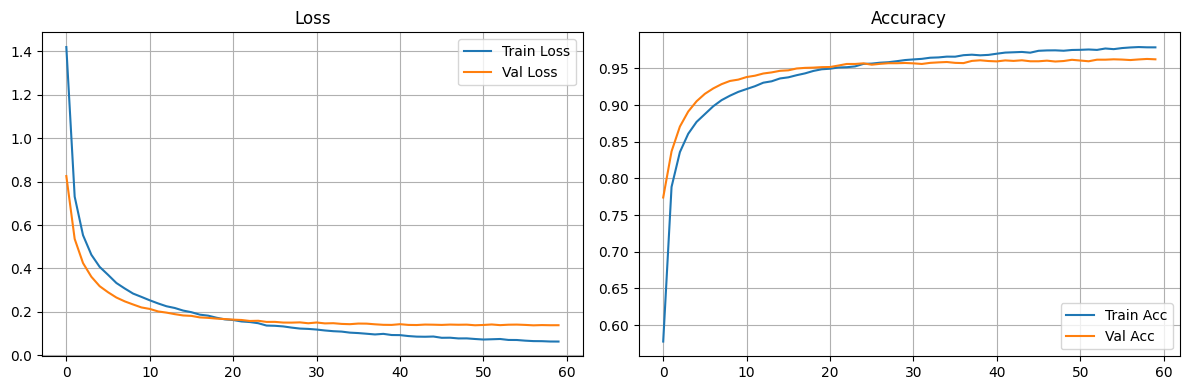

In [9]:

history = trainer.history

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"],   label="Val Loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"],   label="Val Acc")
plt.title("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




Visualized the test (do change)

/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏋️ TRAIN  | Loss: 0.0079 | Acc: 0.9988


/tmp/ipython-input-2705984033.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


🏆 TEST   | Loss: 0.3671 | Acc: 0.9051


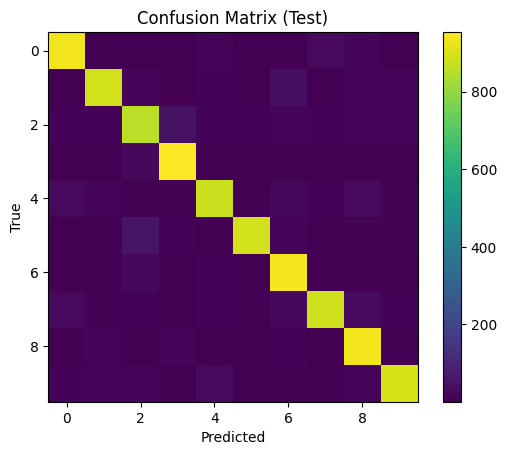

Classification report (Test):
              precision    recall  f1-score   support

           0     0.9148    0.9340    0.9243      1000
           1     0.9154    0.8870    0.9010      1000
           2     0.8415    0.8600    0.8506      1000
           3     0.9094    0.9530    0.9307      1000
           4     0.9086    0.8750    0.8915      1000
           5     0.9653    0.8890    0.9256      1000
           6     0.8689    0.9410    0.9035      1000
           7     0.9364    0.8830    0.9089      1000
           8     0.8728    0.9330    0.9019      1000
           9     0.9324    0.8960    0.9138      1000

    accuracy                         0.9051     10000
   macro avg     0.9065    0.9051    0.9052     10000
weighted avg     0.9065    0.9051    0.9052     10000

📄 Saved Excel results to: Ameer_Espanioly_Baraa_Shaqir_Deema_Shaqir_ex2.xlsx


,experiment,batch_size,epochs,lr,patience,best_val_acc,train_acc,test_acc,layers,train_precision_c0,...,test_f1_c7,test_precision_c8,test_recall_c8,test_f1_c8,test_precision_c9,test_recall_c9,test_f1_c9,test_precision_macro,test_recall_macro,test_f1_macro
0,exp06_weightdecay,128,60,0.0010,8,0.962833,0.998815,0.9051,"[(512, 0.3, True, 0.0001), (256, 0.3, True, 0....",0.997961,...,0.908904,0.872778,0.933,0.901885,0.932362,0.896,0.913819,0.906528,0.9051,0.905173
1,exp08_batch64,64,60,0.0010,8,0.962000,0.996185,0.9033,"[(512, 0.3, True, 0.0), (256, 0.3, True, 0.0),...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,exp04_deeper3,128,60,0.0008,8,0.961500,0.993778,0.9015,"[(512, 0.35, True, 0.0), (256, 0.35, True, 0.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,exp09_batch256,256,50,0.0010,7,0.959667,0.993944,0.8970,"[(512, 0.25, True, 0.0), (256, 0.25, True, 0.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,exp03_deeper2,128,50,0.0010,7,0.959333,0.997889,0.9008,"[(512, 0.3, True, 0.0), (256, 0.3, True, 0.0),...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

def compute_reports(split_name, loader):
    loss, acc = trainer.evaluate(loader)
    preds, targets = trainer.predict_all(loader)

    # classification_report as dict
    rep = classification_report(targets, preds, digits=4, output_dict=True, zero_division=0)
    cm = confusion_matrix(targets, preds)

    # Extract per-class metrics
    per_class = {}
    for cls in range(10):
        cls_key = str(cls)
        if cls_key in rep:
            per_class[f"{split_name}_precision_c{cls}"] = rep[cls_key]["precision"]
            per_class[f"{split_name}_recall_c{cls}"]    = rep[cls_key]["recall"]
            per_class[f"{split_name}_f1_c{cls}"]        = rep[cls_key]["f1-score"]
        else:
            per_class[f"{split_name}_precision_c{cls}"] = np.nan
            per_class[f"{split_name}_recall_c{cls}"]    = np.nan
            per_class[f"{split_name}_f1_c{cls}"]        = np.nan

    # Macro averages
    macro = rep.get("macro avg", {})
    per_class[f"{split_name}_precision_macro"] = macro.get("precision", np.nan)
    per_class[f"{split_name}_recall_macro"]    = macro.get("recall", np.nan)
    per_class[f"{split_name}_f1_macro"]        = macro.get("f1-score", np.nan)

    return float(loss), float(acc), preds, targets, cm, rep, per_class

# ---- TRAIN metrics ----
train_loss, train_acc, train_preds, train_targets, cm_train, rep_train, train_metrics = compute_reports("train", train_loader)
print(f"🏋️ TRAIN  | Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")

# ---- TEST metrics ----
test_loss, test_acc, test_preds, test_targets, cm_test, rep_test, test_metrics = compute_reports("test", test_loader)
print(f"🏆 TEST   | Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")

# ---- Visualize confusion matrix (TEST) ----
plt.figure()
plt.imshow(cm_test)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.show()

print("Classification report (Test):")
print(classification_report(test_targets, test_preds, digits=4, zero_division=0))


best_row = experiments_df.iloc[0].to_dict()

# Add macro + per-class (best model)
best_row.update(train_metrics)
best_row.update(test_metrics)

final_df = pd.DataFrame([best_row] + [r for _, r in experiments_df.iloc[1:].iterrows()])

# Export
excel_path = "Ameer_Espanioly_Baraa_Shaqir_Deema_Shaqir_ex2.xlsx"
final_df.to_excel(excel_path, index=False)
print(f"📄 Saved Excel results to: {excel_path}")

# Log into MLflow as an artifact too
try:
    import mlflow
    mlflow.log_artifact(excel_path)
except Exception as e:
    print("MLflow artifact logging skipped:", e)

final_df.head(5)